<a href="https://colab.research.google.com/github/W-Bernau/dnMBC-Prediction-Model/blob/main/Survival_DL_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Survival_DL_ML Model Replication for SEER Data
###### Will Bernau

# Installing Relevant Dependencies

In [ ]:
!pip install pandas==1.5.3
#Function .is_monotonic has been deprecated since this study was written, so we have to load their version of pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 78.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.


In [ ]:
!pip install scikit-survival
!pip install lifelines
!pip install pycox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 35.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 12.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=df9e5f7cfa44702d4636351a07a00e01ec58e023687f5d4874ad129e2d65fce2
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 5.4 MB/s eta 0:

#Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
from sksurv.datasets import load_gbsg2
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import integrated_brier_score
from sksurv.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, ActivityRegularization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l2
from lifelines import utils
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis

np.random.seed(12345)

# Read the data into a dataframe
##### Note: Since this is written in Colab, you'll need to make sure the notebook has access to your Google drive

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/SEER Model Replication/SEER_Data_09_04.csv', sep = ",")
Sex = {'Male': 1,'Female': 0}
Vital = {'Dead': 1,'Alive': 0}
data.Sex = [Sex[item] for item in data.Sex]
print(data)

         NO  Sex  Age Grade  Race Grade  Primary Site  Grade  \
0      3752    0          2           3             7      3   
1      8303    0          2           1             7      2   
2      7268    0          2           1             5      3   
3      3073    0          3           1             9      1   
4      5027    0          1           2             9      3   
...     ...  ...        ...         ...           ...    ...   
10099  5973    0          3           1             8      2   
10100  6415    0          3           1             7      2   
10101  7058    0          3           1             7      3   
10102  3131    0          2           2             9      2   
10103  6865    0          2           1             9      3   

       Histology Grade I  Histology Grade2  T stage  N stage  ...  \
0                      1                 1        2        1  ...   
1                      1                 1        2        1  ...   
2                      1

# Data Preprocessing
#### Some values from the dataset need to be converted to integers, and then we need to load our data into a numpy array for lin-alg

In [ ]:
Vital = {'Dead': 1,'Alive': 0}
data = np.array(data)
datax = data[:,1:29]
datay = data[:,27:29]
datay[:,1] = [Vital[item] for item in datay[:,1]]

#### Now, the data is split into the train and test sets and normalized

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(datax, datay, test_size=0.2, random_state=114514)
e_train = y_train[:,1]
e_test = y_test[:,1]

X_scaler = StandardScaler().fit(x_train)
X_train = X_scaler.transform(x_train)
X_test = X_scaler.transform(x_test)

Y_scaler = StandardScaler().fit(y_train[:,0].reshape(-1, 1))
Y_train = Y_scaler.transform(y_train[:,0].reshape(-1, 1))
Y_test = Y_scaler.transform(y_test[:,0].reshape(-1, 1))

sort_idx = np.argsort(Y_train.reshape(8083))[::-1]
X_train = X_train[sort_idx]
Y_train = Y_train[sort_idx]
e_train = e_train[sort_idx]

In [ ]:
X_train.shape

(8083, 28)

# **DeepSurv**
######Under this heading will be the construction and examination of the DeepSurv model

###### First, define loss

In [ ]:
## Define the loss function for DeepSurv model
def negative_log_likelihood(E):
    def loss(y_true, y_pred):

        hazard_ratio = tf.math.exp(y_pred)
        log_risk = tf.math.log(tf.math.cumsum(hazard_ratio))
        uncensored_likelihood = tf.transpose(y_pred) - log_risk
        censored_likelihood = uncensored_likelihood * E
        neg_likelihood_ = -tf.math.reduce_sum(censored_likelihood)
        num_observed_events = tf.constant(1, dtype=tf.float32)

        neg_likelihood = neg_likelihood_ / num_observed_events

        return neg_likelihood

    return loss

# Model Construction

In [ ]:
## Define the manual DeepSurv sturcture.
activation = 'relu'
n_nodes = 64
learning_rate = 1e-3
l2_reg = 0.3
dropout = 0.3
lr_decay =  0.9

model = Sequential()
model.add(Dense(units=n_nodes, activation=activation, kernel_initializer='glorot_uniform', input_shape=(28,)))
model.add(Dropout(dropout))
model.add(Dense(units=n_nodes, activation=activation, kernel_initializer='glorot_uniform'))
model.add(Dropout(dropout))
model.add(Dense(units=n_nodes, activation=activation, kernel_initializer='glorot_uniform'))
model.add(Dropout(dropout))
model.add(Dense(units=1, activation='linear', kernel_initializer='glorot_uniform', kernel_regularizer=l2(l2_reg)))
model.add(ActivityRegularization(l2=l2_reg))

optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=learning_rate, decay=lr_decay)

model.compile(loss=negative_log_likelihood(e_train), optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1856      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [ ]:
callbacks = [tf.keras.callbacks.TerminateOnNaN(),
             tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/DeepSurv_SEER.h5', monitor='loss', save_best_only=True, mode='min')]

epochs = 5 #REDUCED FOR THE SAKE OF TIME ON COLAB HOSTED RUNTIME -- CHANGE BACK TO 50 IF MORE RESOURCES ARE AVAILABLE
history = model.fit(X_train, Y_train,
                    batch_size=1,
                    epochs=epochs,
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/5
8069/8083 [============================>.] - ETA: 0s - loss: 0.0170

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8083/8083 [==============================] - 17s 2ms/step - loss: 0.0170
Epoch 2/5
8083/8083 [==============================] - 16s 2ms/step - loss: 9.5875e-07
Epoch 3/5
8083/8083 [==============================] - 15s 2ms/step - loss: 2.6937e-06
Epoch 4/5
8083/8083 [==============================] - 16s 2ms/step - loss: 7.7251e-08
Epoch 5/5
8083/8083 [==============================] - 16s 2ms/step - loss: 1.8830e-06


# Define Concordance Index (C-Index)

In [ ]:
Y_pred_train = np.exp(-model.predict(X_train))
c_index_train = utils.concordance_index(Y_train, Y_pred_train, e_train)
print(f"c-index of training dataset = {c_index_train}")

Y_pred_test = np.exp(-model.predict(X_test))
c_index_test = utils.concordance_index(Y_test, Y_pred_test, e_test)
print(f"c-index of testing dataset = {c_index_test}")

253/253 [==============================] - 0s 1ms/step
c-index of training dataset = 0.5293790744786943
64/64 [==============================] - 0s 1ms/step
c-index of testing dataset = 0.5330168386796251


In [ ]:
SurvY_train = Surv.from_arrays(event=e_train, time=Y_train.reshape(8083,))
SurvY_test = Surv.from_arrays(event=e_test, time=Y_test.reshape(2021,))

Y_pred_train = np.exp(model.predict(X_train))
Y_pred_test = np.exp(model.predict(X_test))


64/64 [==============================] - 0s 1ms/step


In [ ]:
concordance_index_ipcw(SurvY_train,SurvY_test,Y_pred_test.reshape(2021))

ValueError: observed time contains values smaller zero

In [ ]:
concordance_index_ipcw(SurvY_train,SurvY_train,Y_pred_train.reshape(8083))

ValueError: observed time contains values smaller zero

# Integrated Brier Score

In [ ]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter(nelson_aalen_smoothing=False)
naf.fit(Y_train, event_observed=e_train)

baseline = np.array(np.exp(-naf.cumulative_hazard_))

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


In [ ]:
baseline.shape

SurvivalP = baseline.reshape(108)
for prob in Y_pred_test.reshape(2021):
  s = baseline**prob
  SurvivalP = np.vstack([SurvivalP,s.reshape(108)])

In [ ]:
SurvY_train['time'][18:]

array([ 2.78661283,  2.78661283,  2.78661283, ..., -1.25608418,
       -1.25608418, -1.25608418])

In [ ]:
IBS_DeepSurv = integrated_brier_score(SurvY_train, SurvY_test, SurvivalP[1:,1:], SurvY_train['time'][18:])
print(IBS_DeepSurv)

ValueError: observed time contains values smaller zero

## 2. Cox Regression

In [ ]:
## Cox regression here didn't accept negative value in time. Denormalizeation is needed.
SurvY_train = Surv.from_arrays(event=e_train, time=y_train[:,0].reshape(8083,))
SurvY_test = Surv.from_arrays(event=e_test, time=y_test[:,0].reshape(2021,))

In [ ]:
cphNet_model = CoxnetSurvivalAnalysis(fit_baseline_model=True,l1_ratio=0.5)
cphNet_model.fit(X_train, SurvY_train)

CoxnetSurvivalAnalysis(fit_baseline_model=True)

In [ ]:
cph_model = CoxPHSurvivalAnalysis()
cph_model.fit(X_train, SurvY_train)

CoxPHSurvivalAnalysis()

In [ ]:
lower, upper = np.percentile(SurvY_train["time"], [0, 99])
gbsg_times = np.arange(lower, upper)

In [ ]:
cphNet_surv_prob_test = np.row_stack([fn(gbsg_times) for fn in cphNet_model.predict_survival_function(X_test)])
cph_surv_prob_test = np.row_stack([fn(gbsg_times) for fn in cph_model.predict_survival_function(X_test)])

In [ ]:
cphNet_surv_prob_train = np.row_stack([fn(gbsg_times) for fn in cphNet_model.predict_survival_function(X_train)])
cph_surv_prob_train = np.row_stack([fn(gbsg_times) for fn in cph_model.predict_survival_function(X_train)])

## Cox without L1 Penalty

In [ ]:
## Training dataset
integrated_brier_score(SurvY_train, SurvY_train, cphNet_surv_prob_train, gbsg_times)

0.13774022265188318

In [ ]:
integrated_brier_score(SurvY_train, SurvY_test, cphNet_surv_prob_test, gbsg_times)
IBS_CoxNet = integrated_brier_score(SurvY_train, SurvY_test, cphNet_surv_prob_test, gbsg_times)
print(IBS_CoxNet)

0.11185552414608606


In [ ]:
integrated_brier_score(SurvY_train, SurvY_train, cph_surv_prob_train, gbsg_times)

0.13774268620361144

In [ ]:
integrated_brier_score(SurvY_train, SurvY_train, cphNet_surv_prob_train, gbsg_times)

0.13774022265188318

In [ ]:
integrated_brier_score(SurvY_train, SurvY_test, cphNet_surv_prob_test, gbsg_times)
IBS_CoxNet = integrated_brier_score(SurvY_train, SurvY_test, cphNet_surv_prob_test, gbsg_times)
print(IBS_CoxNet)

0.11185552414608606


In [ ]:
## Train dataset
cphNet_model.score(X_train, SurvY_train)

0.6570422067154916

In [ ]:
## Test dataset
cphNet_model.score(X_test, SurvY_test)
CoxNet_Cindex = cphNet_model.score(X_test, SurvY_test)
print(CoxNet_Cindex)

0.6991914653849888


In [ ]:
## Train dataset
cph_model.score(X_train, SurvY_train)

0.6570628848851267

In [ ]:
## Test dataset
cph_model.score(X_test, SurvY_test)
Cox_Cindex = cph_model.score(X_test, SurvY_test)
print(Cox_Cindex)

0.69598593033748


#**3. DeepHit**

In [ ]:
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import torch
import torchtuples as tt

# Normalizing

In [ ]:
e_train = y_train[:,1]
e_test = y_test[:,1]

X_scaler = StandardScaler().fit(x_train)
X_train = X_scaler.transform(x_train).astype('float32')
X_test = X_scaler.transform(x_test).astype('float32')

num_durations = 10
labtrans = DeepHitSingle.label_transform(num_durations)

y_trainDH = labtrans.fit_transform(y_train[:,0],e_train)
y_testDH = labtrans.transform(y_test[:,0],e_test)

train = (X_train, y_trainDH)
test = (X_test, y_testDH)

# Model Building

In [ ]:
in_features = x_train.shape[1]
num_nodes = [256,512,256]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.5

np.random.seed(1234)
_ = torch.manual_seed(123)

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

# Find optimal learning rate

0.0010235310218990308

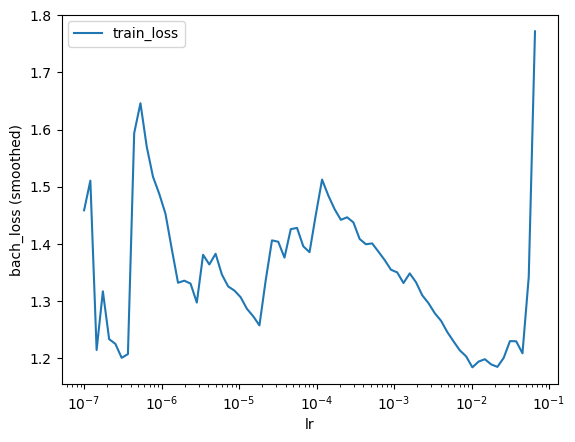

In [ ]:
## Find the optimal learning rate
batch_size = 8
lr_finder = model.lr_finder(X_train, y_trainDH, batch_size, tolerance=10)
_ = lr_finder.plot()
lr_finder.get_best_lr()

# Train the model

In [ ]:
model.optimizer.set_lr(lr_finder.get_best_lr())
epochs = 5 #REDUCED FOR THE SAKE OF TIME ON COLAB HOSTED RUNTIME -- CHANGE BACK TO 100 IF MORE RESOURCES ARE AVAILABLE
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(X_train, y_trainDH, batch_size, epochs, callbacks, val_data=test)

0:	[6s / 6s],		train_loss: 0.6027,	val_loss: 0.3946
1:	[5s / 11s],		train_loss: 0.4548,	val_loss: 0.3485
2:	[5s / 16s],		train_loss: 0.4128,	val_loss: 0.2980
3:	[6s / 22s],		train_loss: 0.3746,	val_loss: 0.2718
4:	[5s / 28s],		train_loss: 0.3377,	val_loss: 0.2399


In [ ]:
duration_test = pd.DataFrame(y_train[:,0])
events_test = pd.DataFrame(e_train)

e = events_test[0].values
e.astype('int32')

d = duration_test[0].values
durations_test = d.astype('float32')

surv = model.predict_surv_df(X_train)

ev = EvalSurv(surv, d.astype('float32'), e.astype('int32'), censor_surv='km')
ev.concordance_td('antolini')

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0.9447201487991292

In [ ]:
duration_test = pd.DataFrame(y_test[:,0])
events_test = pd.DataFrame(e_test)

e = events_test[0].values
e.astype('int32')

d = duration_test[0].values
durations_test = d.astype('float32')

surv = model.predict_surv_df(X_test)
ev = EvalSurv(surv, d.astype('float32'), e.astype('int32'), censor_surv='km')
ev.concordance_td('antolini')

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0.9476419702811693

# Integrated brier score

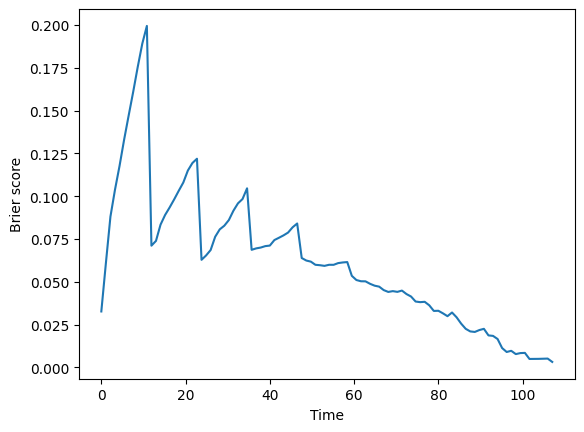

In [ ]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

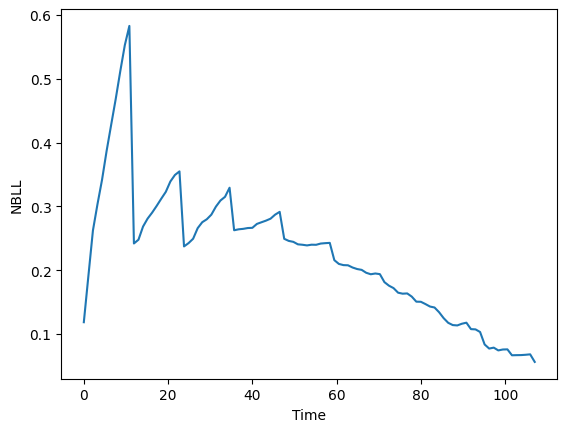

In [ ]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [ ]:
ev.integrated_brier_score(time_grid)

0.06181778539456173

# ComponentWise Gradient Boosting

In [ ]:
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
estimator = ComponentwiseGradientBoostingSurvivalAnalysis(loss="coxph").fit(X_train, SurvY_train)

In [ ]:
estimator.score(X_train, SurvY_train)

0.995786212531135

In [ ]:
estimator.score(X_test, SurvY_test)

0.9983593243391492

In [ ]:
sf_test = np.row_stack([fn(gbsg_times) for fn in estimator.predict_survival_function(X_test)])
integrated_brier_score(SurvY_train, SurvY_test, sf_test, gbsg_times)

0.03302732969775033

In [ ]:
sf_test = np.row_stack([fn(gbsg_times) for fn in estimator.predict_survival_function(X_train)])
integrated_brier_score(SurvY_train, SurvY_train, sf_test, gbsg_times)

0.03147813192798924

# RandomSurvivalForest

In [ ]:
from sksurv.ensemble import RandomSurvivalForest
estimator = RandomSurvivalForest().fit(X_train, SurvY_train)

In [ ]:
chf_train = estimator.predict_cumulative_hazard_function(X_train)
chf_test = estimator.predict_cumulative_hazard_function(X_test)

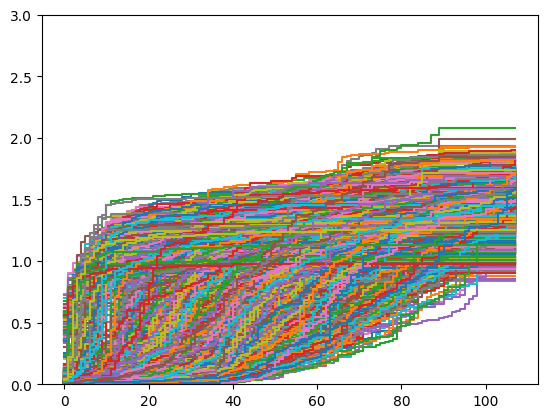

In [ ]:
for fn in chf_test:
    plt.step(fn.x, fn(fn.x), where="post")
plt.ylim(0, 3)
plt.show()

In [ ]:
sv_train = estimator.predict_survival_function(X_train)
sv_test = estimator.predict_survival_function(X_test)

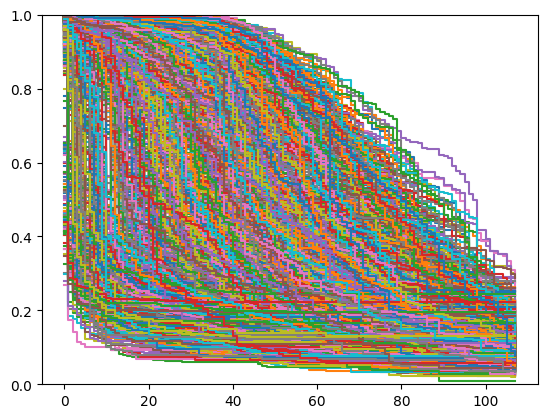

In [ ]:
for fn in sv_test:
    plt.step(fn.x, fn(fn.x), where="post")
plt.ylim(0, 1)
plt.show()

In [ ]:
estimator.score(X_train, SurvY_train)

0.8870083014316208

In [ ]:
estimator.score(X_test, SurvY_test)

0.839013331602578

In [ ]:
sf_test = np.row_stack([fn(gbsg_times) for fn in estimator.predict_survival_function(X_test)])
integrated_brier_score(SurvY_train, SurvY_test, sf_test, gbsg_times)

0.06374254769678979

In [ ]:
sf_test = np.row_stack([fn(gbsg_times) for fn in estimator.predict_survival_function(X_train)])
integrated_brier_score(SurvY_train, SurvY_train, sf_test, gbsg_times)

0.03491188059201374

# FastSurvivalSVM

In [ ]:
from sksurv.svm import FastSurvivalSVM
estimator = FastSurvivalSVM().fit(X_train, SurvY_train)

ValueError: observed time contains values smaller or equal to zero

In [ ]:
## Train dataset
estimator.score(X_train, SurvY_train)

0.8870083014316208

In [ ]:
## Test dataset
estimator.score(X_test, SurvY_test)